***Report Autor: Yassir Abbassi***

# Introduction to the Analysis

In this data analysis assignment, we will explore and interpret raw time-domain data collected from the acceleration sensor mounted on a train wheelset. The sensor captures high-sample accelerometer data along one axe (Not specified). The data is sampled 1-3 times a day while the train is in motion, with each sample lasting for 1 second. If no data exists for a particular day, it indicates that the train was stationary during that time. <u>*It is assumed that the train maintains a constant speed during the measurement.*</u>

The dataset is stored in a CSV file named *data.csv*, which includes **timestamp information**, **GPS speed** at which the sample was captured, and **data rate (DR)** signifying the sampling rate. The **magnitude of the data** is measured in milli-G (mG).

## Assignment Questions

The primary objective of this analysis is to generate insight from the data. The focus is on describing the observed data and understanding how it varies over time. To structure the analysis, the following questions should be addressed:

### Time-Domain Variation:
- How does the data vary in the time-domain over time?
- Are there any discernible trends in the dataset?

### Frequency Content Changes:
- How does the frequency content of the data change?
- Can these changes be described as anomalous or indicate any irregularities?

### Association with Mechanical Performance:
- How could alterations in the data features be linked to changes in the mechanical performance of the wheel, bearing, wheelset, bogie, track, etc.?

These questions guide our exploration into the characteristics of the sensor data and its potential implications on the mechanical aspects of the train components. The analysis will involve visualizations, statistical measures, and any relevant transformations to uncover patterns, trends, and anomalies in the dataset.

# Code

## Context

The language of choice for this analysis is Python, due to its simplicity, and various libraries dedicated for statistics and machine learning. The code section has 3 subsections each with different purposes.

The <u>"Code Dependencies"</u> loads all required libraries, functions and data for this analysis. Afterwards, the <u>*Exploratory Data Analysis (EDA)*</u> takes place. It is a crucial step in the data analysis process that involves examining and summarizing the main characteristics of a dataset. The primary goal of EDA is to gain insights into the underlying patterns, relationships, and distributions within the data before formal modeling or hypothesis testing.

The most important and insightful part is the <u>Time-Domain & Frequency-Domain Analysis*</u>. By inspecting the spectrums of various vibration readings from the sensor, it is possible to deduce whether the signals indicates a faulty equipment, or a normal functioning standard.

Briefly speaking, a vibration data analyst conducts their analysis in different phases:
1.  Data Acquisition: Collects vibration data from sensors mounted on the equipment. The data may include accelerations, velocities, displacements, and temprature over time.

2. Signal Preprocessing: Applies appropriate filters to remove noise and isolate relevant frequency bands, and divide the time-domain signal into segments for detailed analysis.

3. Time-Domain Analysis: Analyzes the amplitudes, calculate statistical measures, and inspect the waveform shape for irregularities.

4. Frequency-Domain Analysis: Involves the identification of prominent **peaks** within the frequency spectrum and the examination of distinct **Frequency Bands**. These peaks could signify resonances, harmonics, or particular fault frequencies. The analysis entails scrutinizing specific frequency bands linked to recognized fault frequencies or machinery components.

**Disclaimer: The dataset furnished for this analysis lacks pertinent details concerning the *Frequency Bands* and the *Fundamental Frequency*. The latter can be computed by leveraging the GPS speed alongside the wheelset's circumference or diameter. Consequently, the precision of the analysis interpretation cannot be assured.**

## Code Dependencies

This section loads all required libraries, functions, and data.

### Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import statistics as stats
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt;#import seaborn as sns;#from tabulate import tabulate

### Custom Functions

In [2]:
#%% Functions
def importData(local):
    # Read as a Pandas Dataframe
    df = pd.read_csv(local, sep=',', decimal='.', header=0)
    N = len(df)
    
    # Convert the timestamp string to a datetime object
    for i in range(N):
        df.iloc[i,1] = datetime.strptime(df.iloc[i,1], "%m/%d/%Y %I:%M:%S %p")
    
    return df, N

def checkNA(df):
    # Check for NA values and print row and column indices
    for index, row in df.iterrows():
        for col in df.columns:
            if pd.isna(row[col]):
                print(f"NA found at row {index}, column {col}")

def freqAnalysis(reading, sampling_rate):
    # Perform Fourier Transform to calculate the frequency spectrum
    fft_result = np.fft.fft(reading)
    fft_freq = np.fft.fftfreq(len(reading), d=1.0/sampling_rate)

    # Keep only positive frequencies (excluding the mirrored negative frequencies)
    positive_freq_mask = fft_freq > 0
    fft_freq = fft_freq[positive_freq_mask]
    fft_result = fft_result[positive_freq_mask]

    # Calculate the magnitude spectrum (absolute values of complex numbers)
    magnitude_spectrum = np.abs(fft_result)
    
    return fft_result, fft_freq, magnitude_spectrum

### Import Dataset

In [3]:
data, N = importData('data.csv')
tmstmp = data.iloc[:,1]

# Three main sets
dr = data['dr']; dr.index = tmstmp.values.tolist()
g = data.iloc[:,3:].transpose(); g.columns = tmstmp.values.tolist()
v = data.iloc[:,0].transpose(); v.index = tmstmp.values.tolist()

## Exploratory Data Analysis
### Data Preprocessing
#### Statistics Definition
Before starting the *EDA*, the data should be preporcessed. The code below create the necessary data vectors for this analysis. Here is the description of each variable:

- **g_mu** *(Acceleration mean)*: The mean in this case represents the value of which an acceleration reading is centered around. Since the vibrational data oscillate between negative and positive values, with nearly same amplitudes, the means are very close to zero.

$$\mu_{acceleration}=\frac{1}{n}\Sigma_{i=1}^na_{i}$$


- **g_pk_mu** *(Acceleration Peak mean)*: To avoid data cancelation in the typical mean value, the mean of absolute values only focuses on amplitudes. Therefore, the information of the absolute mean is more representative in case of oscillating data.

$$\mu_{\|pk\|}=\frac{1}{n}\Sigma_{i=1}^n\|a_{i}\|$$


- **g_rms** *(Acceleration Root Mean Square)*: RMS describes best alternating physical values. It takes into account the signal amplitude and duration, and represents the power or energy associated with the physical value (vibrations).

$$a_{rms}=\sqrt{\frac{1}{n}\Sigma_{i=1}^na_{i}^2}$$


- **g_sigma** *(Acceleration standard deviation)*: The vibrational data are very representative of the health of the physical system. If the equipments are damaged, multiple frequencies related to the damaged equipment will have increased magnitudes. Consequently, the time-domain signal will have a more dispersed amplitudes, instead of smooth vibrational signals.

$$\sigma_{acceleration}=\sqrt{\frac{\Sigma_{i=1}^n(a_{i}-\mu)^2}{n-1}}$$


- **g_min** *(Max acceleration)*:

$$a_{min}=\min{a}$$


- **g_max** *(Min acceleration)*:

$$a_{max}=\max{a}$$

In [4]:
# Relevant data
## Central tendency
g_mu = g.mean()
g_pk_mu = abs(g).mean()
g_rms = np.sqrt((g**2).mean())

## Deviation
g_sigma = g.std()

## Mins & Maxs
g_min = g.min()
g_max = g.max()

#### Normalization of data

To plot the data and visually identify their patterns, scalling helps to cram the data into a small interval. The advantage of *Min-Max Normalization* method lies in the fact that the data do not lose their true scale. Unlike Z-score for example, where data lose their scale and therefore, its original meaning.

$$X_{\text{normalized}} = \frac{X - \text{min}(X)}{\text{max}(X) - \text{min}(X)}$$


This snippet of code construct 5 important normalized vector only aimed for visualization:

- **g_mu_n**: Normalized Acceleration Mean

- **g_pk_mu_n**: Normalized Acceleration Peaks Mean

- **g_rms_n**: Normalized Acceleration RMS

- **g_sigma_n**: Normalized Acceleration Standard Deviation

- **v_n**: Normalized Speed

In [5]:
scaler = MinMaxScaler()

g_mu_n = pd.DataFrame(scaler.fit_transform(g_mu.values.reshape(-1,1)))
g_pk_mu_n = pd.DataFrame(scaler.fit_transform(g_pk_mu.values.reshape(-1,1)))
g_rms_n = pd.DataFrame(scaler.fit_transform(g_rms.values.reshape(-1,1)))

g_sigma_n = pd.DataFrame(scaler.fit_transform(g_sigma.values.reshape(-1,1)))
v_n = pd.DataFrame(scaler.fit_transform(v.values.reshape(-1,1)))

### Descriptive Statistics

In [6]:
# Check minimums and maximums RMS values
hm = g_pk_mu.idxmax();lm = g_pk_mu.idxmin();hs = g_sigma.idxmax();ls = g_sigma.idxmin()
print("Date of highest peaks mean:\t{}".format(hm))
print("Date of lowest peaks mean:\t{}".format(lm))
print("Date of highest std.:\t\t{}".format(hs))
print("Date of lowest std.:\t\t{}\n".format(ls))

# Check dimensions
print("Dataset dimensions:\t{}\n".format(data.shape))

# Check existence of empty cells
print("List of coordinates of empty cells:\n{}\n".format(checkNA(data)))

# Description of absolute value of 1st 4 numerical features of the dataset
print("Summary of 1st 8 days peak acceleration values:\n{}".format(abs(g).iloc[:,0:8].describe()))

Date of highest peaks mean:	2023-09-24 23:37:20
Date of lowest peaks mean:	2023-10-16 21:20:26
Date of highest std.:		2023-09-24 23:37:20
Date of lowest std.:		2023-10-16 21:20:26

Dataset dimensions:	(62, 6403)

List of coordinates of empty cells:
None

Summary of 1st 8 days peak acceleration values:
       2023-05-04 05:50:39  2023-05-12 21:46:41  2023-05-14 03:43:54  \
count          6400.000000          6400.000000          6400.000000   
mean           1123.507491           494.164009           595.615946   
std             884.203013           412.898035           544.332637   
min               0.055825             0.026259             0.045001   
25%             424.449371           182.705910           213.607198   
50%             932.746197           397.891694           458.808560   
75%            1605.554909           692.877530           815.623887   
max            6245.104152          3177.946634          5424.988162   

       2023-05-20 22:58:32  2023-05-22 01:03:03 

**Outline 1**

1. The data have no empty values


2. The recordings happened in distinct 62 occasions.

3. The strongest vibration was recorded on *2023-09-24 at 23:37:20*, which is the same time mean vibration was at its highest amoung the readings.

4. Similarly, the weakest vibration was recorded on *2023-10-16 at 21:20:26*, the same time the mean vibration was at its lowest amoung the readings.

5. The first 8 readings statistics clearly show a single pattern, which is that all values increase or decrease simultaneously.

6. The last 3 readings happened on the same day 2023-06-01, at 12 AM, 1 PM and 5 PM. The data shows different peak means, which are all proportionate to the train speed at the first glance.

#### Key Pearson's Correlations

In [7]:
corr1 = np.corrcoef(g_mu_n.iloc[:,0], v_n.iloc[:,0])
corr2 = np.corrcoef(g_pk_mu_n.iloc[:,0], v_n.iloc[:,0])
corr3 = np.corrcoef(g_rms_n.iloc[:,0], v_n.iloc[:,0])
corr4 = np.corrcoef(g_sigma_n.iloc[:,0], v_n.iloc[:,0])

print("Correlation(Mean, Velocity)\t\t=\t{}\n".format(corr1[0,1]))
print("Correlation(Peaks Mean, Velocity)\t=\t {}\n".format(corr2[0,1]))
print("Correlation(RMS, Velocity)\t\t=\t {}\n".format(corr3[0,1]))
print("Correlation(Std., Velocity)\t\t=\t {}\n".format(corr4[0,1]))

Correlation(Mean, Velocity)		=	-0.13873125000472503

Correlation(Peaks Mean, Velocity)	=	 0.8025863728348541

Correlation(RMS, Velocity)		=	 0.8014602553827936

Correlation(Std., Velocity)		=	 0.8014602553827935



**Outline 2**

There is a strong correlation between, acceleration's peaks mean, RMS and standard deviation with the train velocity. Which means that the train speed is a very relevant feature in this analysis. Therefore, the following analysis must be conducted with train speed in perspective.

#### Visualization - Rolling Statistics with Normalized Acceleration Data

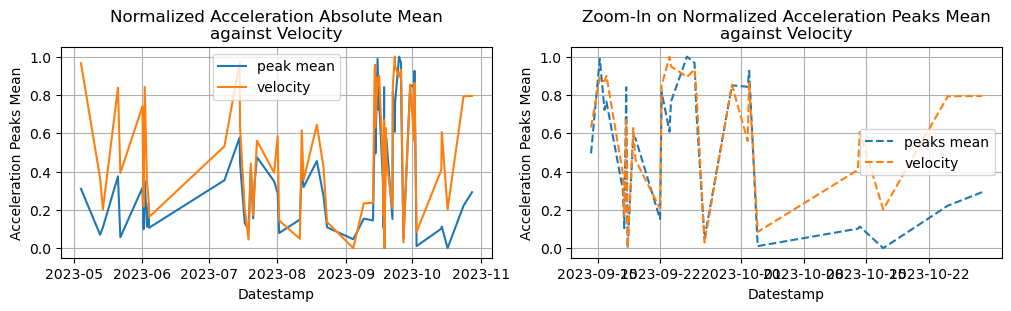

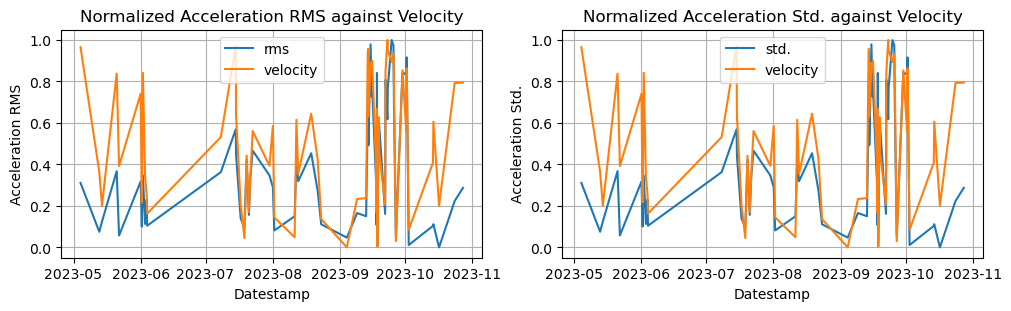

In [8]:
# Absolute Values Mean
fig1, ax1 = plt.subplots(1, 2, figsize=(10, 3), layout="constrained")
ax1[0].plot(tmstmp, g_pk_mu_n, label='peak mean')
ax1[0].plot(tmstmp, v_n,label='velocity')
ax1[0].set(xlabel='Datestamp', ylabel='Acceleration Peaks Mean',
           title='Normalized Acceleration Absolute Mean\nagainst Velocity')
ax1[0].grid()
ax1[0].legend()

ax1[1].plot(tmstmp[35:62], g_pk_mu_n[35:62], '--', label='peaks mean')
ax1[1].plot(tmstmp[35:62], v_n[35:62],  '--', label='velocity')
ax1[1].set(xlabel='Datestamp', ylabel='Acceleration Peaks Mean',
           title='Zoom-In on Normalized Acceleration Peaks Mean\nagainst Velocity')
ax1[1].grid()
ax1[1].legend()

fig1.savefig("media/Fig1.png")
plt.show()


# RMS & Std.
fig2, ax2 = plt.subplots(1, 2, figsize=(10, 3), layout="constrained")
ax2[0].plot(tmstmp, g_rms_n, label='rms')
ax2[0].plot(tmstmp, v_n, label='velocity')
ax2[0].set(xlabel='Datestamp', ylabel='Acceleration RMS',
           title='Normalized Acceleration RMS against Velocity')
ax2[0].grid()
ax2[0].legend()

ax2[1].plot(tmstmp, g_sigma_n, label='std.')
ax2[1].plot(tmstmp, v_n, label='velocity')
ax2[1].set(xlabel='Datestamp', ylabel='Acceleration Std.',
           title='Normalized Acceleration Std. against Velocity')
ax2[1].grid()
ax2[1].legend()

fig2.savefig("media/Fig2.png")
plt.show()

**Outline 3**

The role of velocity in contributing to vibrations is evident; however, it is essential to note that **this contribution is not uniform, specifically lacking <u>linearity</u>**. Numerous variables associated with the mechanical aspects of the train system come into play, influencing the nature of this contribution.

The increase in vibration strength indicators in both time-domain analyses as the speed of a train increases can be attributed to several factors related to the dynamics of the train-wheel-track system. Some of the reasons are:

1. **Resonance Effects**: At higher speeds, the train components (wheelsets, axles, etc.) may resonate at specific frequencies. When the excitation frequency (related to the train speed & circonference of the wheelset) matches the natural frequency of a component, resonance can occur, leading to an amplification of vibrations. This effect can result in higher vibration amplitudes.
<br>

2. **Wheel-Track Interaction**: The interaction between the train wheels and the track can become more dynamic at higher speeds. Wheel-track interaction generates vibrations, and these interactions may intensify with speed, leading to an increase in vibration strength.
<br>

3. **Wheel Imbalances or Wear**: Imbalances in the train wheels or uneven wear on the wheels can lead to vibrations. At higher speeds, the effects of wheel imbalances or wear become more pronounced, resulting in increased vibration strength.
<br>

4. **Increased Kinetic Energy**: The kinetic energy of the moving train increases with speed. This higher kinetic energy is transferred to the components of the train-wheel-track system, leading to an increase in vibrational energy.


To better understand the nonlinear component(s) of the velocity and the acceleration, the following graph plots the velocity against how much velocity contributed to the acceleration values, where:

- X-axis: Normalized values of velocity scaled from 0 to 1.

- Y-axis: Normalized values of velocity's contribution to the acceleration $y_{contribution}=Velocity - Acceleration$.

Mean Squared Error: 0.030630123678473748


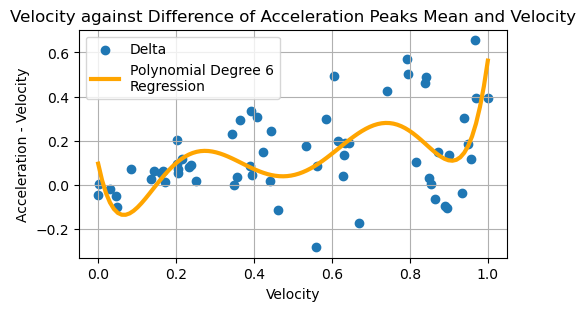

In [9]:
# Absolute Values Mean and Velocity Study
deltaVG = v_n - g_pk_mu_n

## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(v_n, deltaVG, test_size=0.2, random_state=42)

## Create a Polynomial Regression model
degree = 6  # Degree of the polynomial
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

## Train the model
model.fit(X_train, y_train)

## Make predictions on the test set
y_pred = model.predict(X_test)

## Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

## Generate X values for plotting the curve
X_curve = np.linspace(0, 1, 100).reshape(-1, 1)
y_curve = model.predict(X_curve)

## Plot
fig3, ax3 = plt.subplots(figsize=(5, 3), layout="constrained")
ax3.scatter(v_n, deltaVG, label='Delta')
plt.plot(X_curve, y_curve, color='orange', linewidth=3, label=f'Polynomial Degree {degree}\nRegression')
ax3.set(xlabel='Velocity', ylabel='Acceleration - Velocity',
           title='Velocity against Difference of Acceleration Peaks Mean and Velocity')
ax3.grid()
plt.legend()

fig3.savefig("media/Fig3.png")
plt.show()

**Outline 4**

* The implementation of polynomial regression serves to elucidate the nonlinearity inherent in the correlation between velocity and its corresponding contribution. Noticeably, when considering the min-max scale, the graphical representation substantiates an observable growing trend in the association between these two variables.

* In summation, there is a proportional increase in vibrations concomitant with increases in velocity. However, noteworthy is the discernible impact of specific velocities, indicative of a discernible influence analogous to **resonance frequencies** on the dataset.

## Time-domain & Frequency Domain Signals
### Time-Domain Signals

In [10]:
t = np.arange(0.0, 1.0, 0.00015625)

fig4, ax4 = plt.subplots(2, 1, figsize=(10, 4))
ax4[0].plot(t, g[hm]/1000, 'r-', label = str(round(v[hm], 2))+" km/h" )
ax4[0].set(xlabel='Time (s)',
              ylabel='Amplitude (G)',
              title=str(hm)+" (Highest peaks mean & std.)")
ax4[0].grid()
ax4[0].legend()

ax4[1].plot(t, g[lm]/1000, label = str(round(v[lm], 2))+" km/h" )
ax4[1].set(xlabel='Time (s)',
              ylabel='Amplitude (G)',
              title=str(lm) + " (Lowest peaks mean & std.)")
ax4[1].grid()
ax4[1].legend()

fig4.tight_layout()
fig4.savefig("media/Fig4.png")
plt.show()

**Outline 5**

The plots above are time-domain signal of acceleration on two key datestamps. On 2023-09-24 at 23:37:20 reading recorded the highest peaks mean and deviation, where the acceleration reached 10 G in magnitude. Inversly, the lowest peaks are recorded on 2023-10-16 at 21:20:26 with a maximum magnitude of 1 G.

In [11]:
# Max & Min V

hs = tmstmp[ np.where(v == max(v))[0][0] ]
ls = tmstmp[ np.where(v == min(v))[0][0] ]

fig5, ax5 = plt.subplots(2, 1, figsize=(10, 4))
ax5[0].plot(t, g[hs]/1000, 'r-', label = str(round(v[hs], 2))+" km/h" )
ax5[0].set(xlabel='Time (s)',
              ylabel='Amplitude (G)',
              title=str(hs)+" (Highest velocity)")
ax5[0].grid()
ax5[0].legend()

ax5[1].plot(t, g[ls]/1000, label = str(round(v[ls], 2))+" km/h" )
ax5[1].set(xlabel='Time (s)',
              ylabel='Amplitude (G)',
              title=str(ls) + " (Lowest velocity)")
ax5[1].grid()
ax5[1].legend()

fig5.tight_layout()
fig5.savefig("media/fig5.png")
plt.show()

**Outline 5**

Vibrations are significantly higher at 101.4 km/h compared to 26.36 km/h. While speed generally contributes to vibrations, specific train speeds, possibly due to **resonance frequencies** or **faulty equipment**, have a more pronounced impact on vibration levels.

### Frequency Domain Analysis
#### Reading when vibrations are the strongest

In [12]:
# "2023-09-24 23:37:20"
datestamp = "2023-09-24 23:37:20"
reading = g[datestamp]/1000
samplingRate = dr[datestamp]
threshold = 300

_, fft_freq, magnitude_spectrum = freqAnalysis(reading, samplingRate)
peaksA, _ = find_peaks(magnitude_spectrum, height = threshold)

In [13]:
fig4, ax5 = plt.subplots(figsize=(10, 4))
ax5.plot(fft_freq, magnitude_spectrum, label='Speed = {}'.format(v[datestamp]))
ax5.plot(fft_freq[peaksA], magnitude_spectrum[peaksA], 'x', label='Peaks')
ax5.set(xlabel = 'Frequency (Hz)',
            ylabel = 'Magnitude (G)',
            title = 'Frequency Spectrum of Accelerometer Data on {}'.format(reading.name))
ax5.grid()
ax5.legend()

In [14]:
print("Peak with highest Magnitude:\t{} Hz\t\twith a magnitude of {} G".format(peaksA[(magnitude_spectrum[peaksA] == max(magnitude_spectrum[peaksA]))][0], round(max(magnitude_spectrum[peaksA]), 2) ))
print("Peak with lowest Magnitude :\t{} Hz\t\twith a magnitude of {} G".format(peaksA[(magnitude_spectrum[peaksA] == min(magnitude_spectrum[peaksA]))][0], round(min(magnitude_spectrum[peaksA]), 2) ))

Peak with highest Magnitude:	2118 Hz		with a magnitude of 1736.64 G
Peak with lowest Magnitude :	424 Hz		with a magnitude of 302.1 G


#### Reading when vibrations are the weakest

In [15]:
# "2023-10-16 21:20:26"
datestamp = "2023-10-16 21:20:26"
reading = g[datestamp]/1000
samplingRate = dr[datestamp]
threshold = 70

_, fft_freq, magnitude_spectrum = freqAnalysis(reading, samplingRate)
peaksB, _ = find_peaks(magnitude_spectrum, height = threshold)

In [16]:
fig5, ax6 = plt.subplots(figsize=(10, 4))
ax6.plot(fft_freq, magnitude_spectrum, label='Speed = {}'.format(v[datestamp]))
ax6.plot(fft_freq[peaksB], magnitude_spectrum[peaksB], 'x', label='Peaks')
ax6.set(xlabel = 'Frequency (Hz)',
            ylabel = 'Magnitude',
            title = 'Frequency Spectrum of Accelerometer Data on {}'.format(reading.name))
ax6.grid()
ax6.legend()

In [17]:
print("Peak with highest Magnitude:\t{} Hz\t\twith a magnitude of {} G".format(peaksB[(magnitude_spectrum[peaksB] == max(magnitude_spectrum[peaksB]))][0], round(max(magnitude_spectrum[peaksB]), 2) ))
print("Peak with lowest Magnitude :\t{} Hz\t\twith a magnitude of {} G".format(peaksB[(magnitude_spectrum[peaksB] == min(magnitude_spectrum[peaksB]))][0], round(min(magnitude_spectrum[peaksB]), 2) ))

Peak with highest Magnitude:	500 Hz		with a magnitude of 295.11 G
Peak with lowest Magnitude :	42 Hz		with a magnitude of 70.98 G


#### Reading when Vibrations have median velocity

In [18]:
# "2023-07-08 01:45:21"
datestamp = v.index[np.argsort(v)[len(v)//2]]
reading = g[datestamp]/1000
samplingRate = dr[datestamp]
threshold = 200

_, fft_freq, magnitude_spectrum = freqAnalysis(reading, samplingRate)
peaksC, _ = find_peaks(magnitude_spectrum, height = threshold)

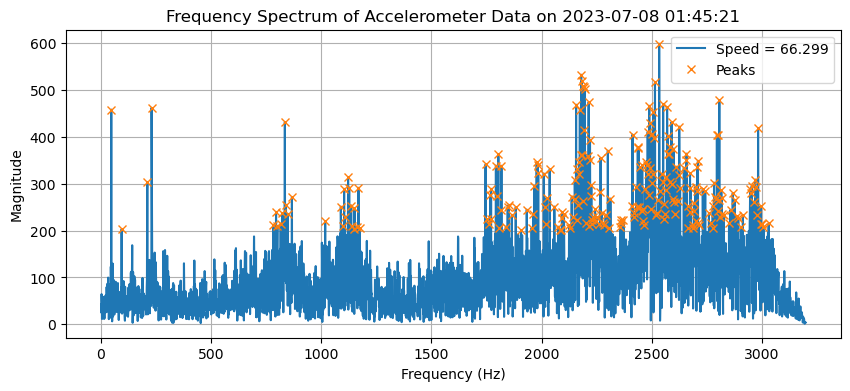

In [19]:
fig5, ax6 = plt.subplots(figsize=(10, 4))
ax6.plot(fft_freq, magnitude_spectrum, label='Speed = {}'.format(v[datestamp]))
ax6.plot(fft_freq[peaksC], magnitude_spectrum[peaksC], 'x', label='Peaks')
ax6.set(xlabel = 'Frequency (Hz)',
            ylabel = 'Magnitude',
            title = 'Frequency Spectrum of Accelerometer Data on {}'.format(reading.name))
ax6.grid()
ax6.legend()

In [20]:
print("Peak with highest Magnitude:\t{} Hz\t\twith a magnitude of {} G".format(peaksC[(magnitude_spectrum[peaksC] == max(magnitude_spectrum[peaksC]))][0], round(max(magnitude_spectrum[peaksC]), 2) ))
print("Peak with lowest Magnitude :\t{} Hz\t\twith a magnitude of {} G".format(peaksC[(magnitude_spectrum[peaksC] == min(magnitude_spectrum[peaksC]))][0], round(min(magnitude_spectrum[peaksC]), 2) ))

Peak with highest Magnitude:	2533 Hz		with a magnitude of 598.69 G
Peak with lowest Magnitude :	2083 Hz		with a magnitude of 200.98 G


#### Frequency Domain Interpretation:

Higher frequencies dominate the spectrum at high speeds and lower frequencies dominate at low speeds, might be associated with the Doppler effect in the context of vibration signals.

The Doppler effect is commonly observed in various wave phenomena, including sound waves, light waves, and vibration waves. In the context of train vibrations, it can lead to a shift in the dominant frequencies depending on the relative motion between the sensor and the source of vibrations.

However, when the sensor is mounted on the train wheelset and moves at the same speed as the train, the Doppler effect is unlikely to be the main factor affecting the observed frequency content in accelerometer data.

In such cases, other elements could contribute to the changes in frequency content with train speed:

- **Resonance Effects:**
  - Mechanical components like the wheelset, axles, or other parts may resonate at specific frequencies. Higher speeds might lead to increased energy at these resonant frequencies.

- **Track Irregularities:**
  - Track conditions can impact vibrations transmitted to the wheelset. Irregularities, such as joints, switches, or uneven track geometry, may introduce specific frequency components that vary with speed.

- **Wheel-Track Interaction:**
  - The interaction between train wheels and the track can result in different dynamic behaviors at varying speeds, influencing the frequency content of vibrations.

- **Wheel Imperfections:**
  - Train wheel imperfections, like flat spots or uneven wear, can introduce specific frequencies into vibrations. The prominence of these frequencies may change with speed.

- **Train Suspension System:**
  - The design and condition of the train suspension system can affect how vibrations are transmitted through the wheelset. Changes in speed may impact the dynamics of the suspension system.

Understanding these factors and the specific characteristics of the train system is crucial for accurately interpreting the frequency content in accelerometer data. Experimental validation and collaboration with domain experts familiar with the specific train system can provide valuable insights into the factors influencing observed vibration patterns at different speeds.